In [2]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsa.ts_utils import * 
from scripts.python.tsa.utsmodel import * 
from scripts.python.tsa.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
modeldir = os.getcwd() + "/data/tourism/palau/model/"
filepaths = [filedir + file for file in os.listdir(filedir) if ".csv" in file]
filepaths

['/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_merged.csv',
 '/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_monthly_visitor.csv']

## Preprocessing
### Use `stringency_index` as a proxy

In [3]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [4]:
oceania_index["year"], oceania_index["month"] = \
    oceania_index["date"].dt.year, oceania_index["date"].dt.month
oceania_index = oceania_index.groupby(["year", "month"]).mean().reset_index()
oceania_index["date"] = [str(year) + "-" + str(month)
                         for year, month in zip(oceania_index.year, oceania_index.month)]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])

In [5]:
oceania_index.to_csv(
    os.getcwd() + "/data/tourism/oceania_covid_stringency.csv", encoding="utf-8")
oceania_index.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [6]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_palau.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,palau flights-AU,palau hotel-AU,palau travel-AU,palau flights-NZ,palau hotel-NZ,palau travel-NZ,palau flights-US,palau hotel-US,palau travel-US,...,palau travel-JP,palau flights-HK,palau hotel-HK,palau travel-HK,palau flights-NC,palau hotel-NC,palau travel-NC,palau flights,palau hotel,palau travel
0,2004-01-01,0,0,0,0,0,0,0,23,0,...,0,0,0,0,0,0,0,0.0,3.155717,3.055298
1,2004-02-01,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0.0,5.111154,2.142547
2,2004-03-01,0,63,0,0,0,0,0,0,0,...,0,0,90,0,0,0,0,0.0,6.132983,2.768303
3,2004-04-01,0,0,0,0,0,0,0,0,100,...,0,0,0,0,0,0,0,0.0,10.537711,0.000000
4,2004-05-01,0,0,0,0,0,0,22,0,0,...,0,0,0,0,0,0,0,0.0,7.344062,0.000000


### Read Palau's intermediate files

In [7]:
palau = pd.read_csv(filepaths[-1]).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(gt[["date", "palau travel"]], left_on="Date", right_on="date")
         .merge(oceania_index, how="left", on="date")
              .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid",
                  "palau travel": "palau_travel"}, axis=1))
palau.to_csv(modeldir + "palau_for_utsa.csv", encoding="utf-8")
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,palau_travel,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.320004,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.952482,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.453967,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.000000,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.000000,0.0,0.0,0.0


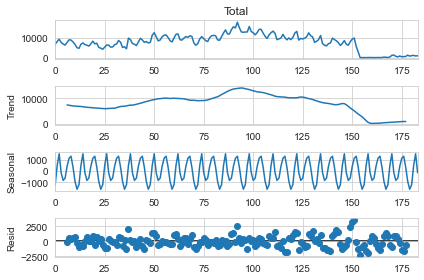

In [8]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

In [72]:
p, d, q = range(0, 3), range(0, 2), range(0, 3)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))

sl_series = scaledlogit_transform(palau["Total"])
for arima_order in pdq:
    stlf = STLForecast(sl_series,  ARIMA, model_kwargs=dict(
        order=arima_order, trend="t", exog=palau[["palau_travel", "covid"]]), period=12)
    stlf_res = stlf.fit()

    stlf_df = stlf_res.get_prediction().summary_frame()

    upper = palau["Total"].max() + 1
    lower = palau["Total"].min() - 1
    for idx, val in enumerate(stlf_df["mean"]):
        stlf_df.iloc[idx, 0] = inverse_scaledlogit(val, upper, lower)
    stlf_df["total"] = palau["Total"]
    
    print(arima_order)
    print(calculate_evaluation(stlf_df["total"], stlf_df["mean"]))

(0, 0, 0)
{'MSE': 5186949.381233512, 'RMSE': 2277.487515055464, 'MAE': 1704.8870802482813, 'SMAPE': 37.833075101197856}
(0, 0, 1)
{'MSE': 3546928.613173521, 'RMSE': 1883.3291303363628, 'MAE': 1361.390364033203, 'SMAPE': 30.44769098126891}
(0, 0, 2)
{'MSE': 2813066.2429886335, 'RMSE': 1677.2197956703926, 'MAE': 1188.6727202637487, 'SMAPE': 27.037041259620274}
(0, 1, 0)
{'MSE': 2076369.827897392, 'RMSE': 1440.9614248471025, 'MAE': 852.0334028145295, 'SMAPE': 19.79138194878925}
(0, 1, 1)
{'MSE': 1880399.444055666, 'RMSE': 1371.2765746032658, 'MAE': 885.8947574086935, 'SMAPE': 21.321596329915717}
(0, 1, 2)
{'MSE': 1856148.1925504988, 'RMSE': 1362.4052967272619, 'MAE': 881.6644375124299, 'SMAPE': 21.11556564908809}
(1, 0, 0)
{'MSE': 1980776.1849276572, 'RMSE': 1407.4005062268725, 'MAE': 927.671297147423, 'SMAPE': 20.70412232970043}
(1, 0, 1)
{'MSE': 1843195.9957803984, 'RMSE': 1357.6435451842278, 'MAE': 902.3347704175783, 'SMAPE': 20.86730040820281}
(1, 0, 2)
{'MSE': 1841663.571174484, 'RMS

{'MSE': 1116252.5468997676, 'RMSE': 1056.528535771641, 'MAE': 664.048336428669, 'SMAPE': 26.100274458719696}


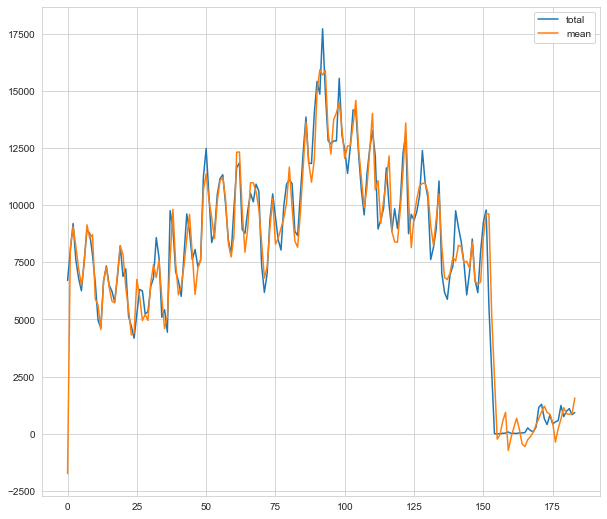

In [79]:
stlf = STLForecast(palau["Total"],  ARIMA, model_kwargs=dict(
    order=(1,0,1), trend="t", exog=palau["palau_travel"]), period=12)
stlf_res = stlf.fit()

stlf_df = stlf_res.get_prediction().summary_frame()
stlf_df["total"] = palau["Total"]
stlf_df[["total", "mean"]].plot()
print(calculate_evaluation(stlf_df["total"], stlf_df["mean"]))

## SARIMAX

In [9]:
naive_pred = naive_method(palau["Total"])
mean_pred = mean_method(palau["Total"])
snaive_pred = seasonal_naive_method(palau["Total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(palau["Total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,SMAPE
naive,2.096767e+06,1448.021907,1092.759563,23.272616
mean,1.639656e+07,4049.266859,3178.648757,51.716972
seasonal naive,1.123704e+07,3352.169852,2405.935201,56.509474


## Best No-Transformation Models (existence of negative values)

,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total,stringency_index,covid,palau_flights,palau_hotel,palau_travel
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,1.068426,8.334537,0.320004
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.000000,9.667343,0.952482
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.704914,6.906282,0.453967
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.798284,3.591027,0.000000
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.431326,4.111283,0.000000


training size : 184, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1543.442
Date:                            Wed, 14 Jun 2023   AIC                           3102.884
Time:                                    23:22:11   BIC                           3128.560
Sample:                                         0   HQIC                          3113.292
                                            - 184                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

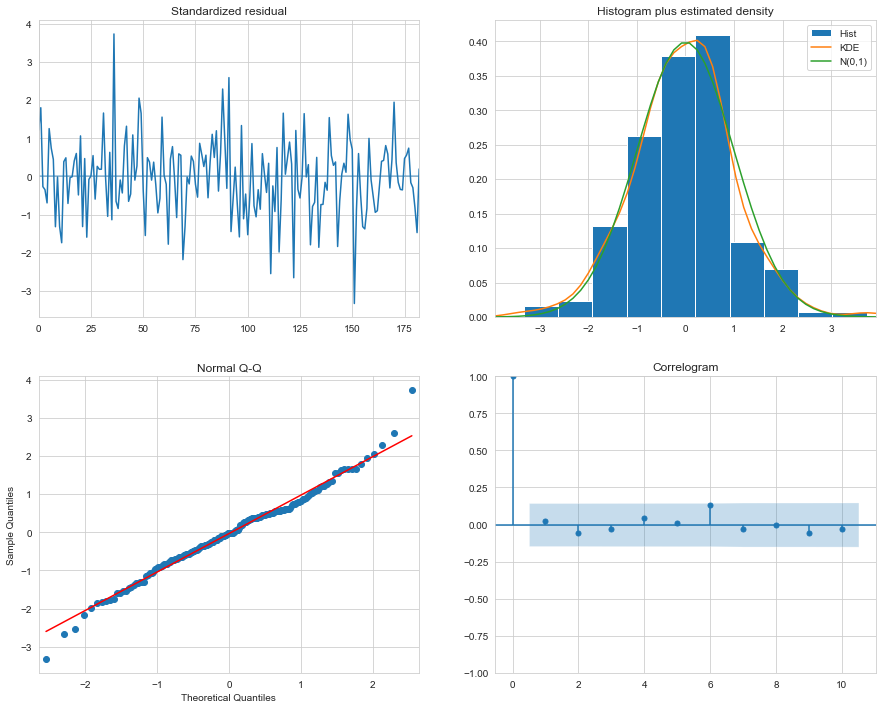

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

LU decomposition error.
STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(1,1,1)(0,1,1)[12] intercept 



In [10]:
from sarimaxs import run_sarimax
palau_original = run_sarimax(country="palau", 
                             y_vars=["total"],
                             exog_var=["covid", "stringency_index", "palau_travel"],
                             method=None)

<AxesSubplot:xlabel='date', ylabel='value'>

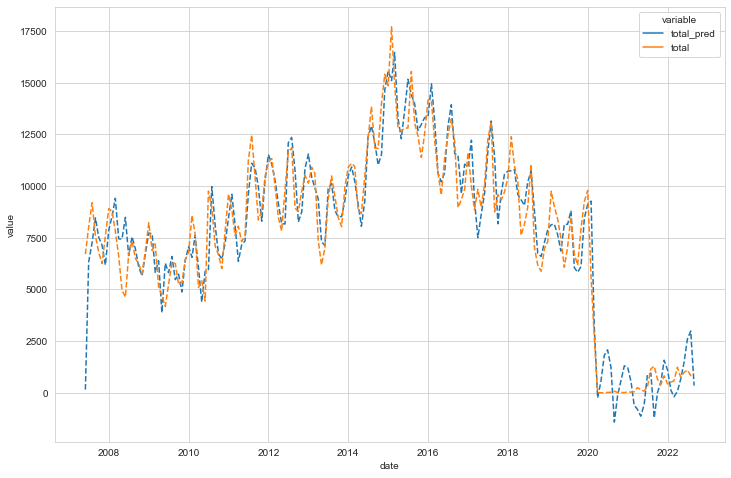

In [11]:
original_viz_df = palau_original[["date", "total_pred", "total"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=original_viz_df, x="date", y="value", hue="variable", linestyle="--")

In [12]:
calculate_evaluation(palau_original["total"], palau_original["total_pred"])

{'MSE': 1583197.8090866506,
 'RMSE': 1258.25188618442,
 'MAE': 940.1454114166537,
 'SMAPE': 34.16009452287052}

,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total,stringency_index,covid,palau_flights,palau_hotel,palau_travel
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,1.068426,8.334537,0.320004
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.000000,9.667343,0.952482
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.704914,6.906282,0.453967
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.798284,3.591027,0.000000
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.431326,4.111283,0.000000


training size : 184, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -231.652
Date:                            Wed, 14 Jun 2023   AIC                            477.305
Time:                                    23:29:57   BIC                            499.809
Sample:                                         0   HQIC                           486.426
                                            - 184                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

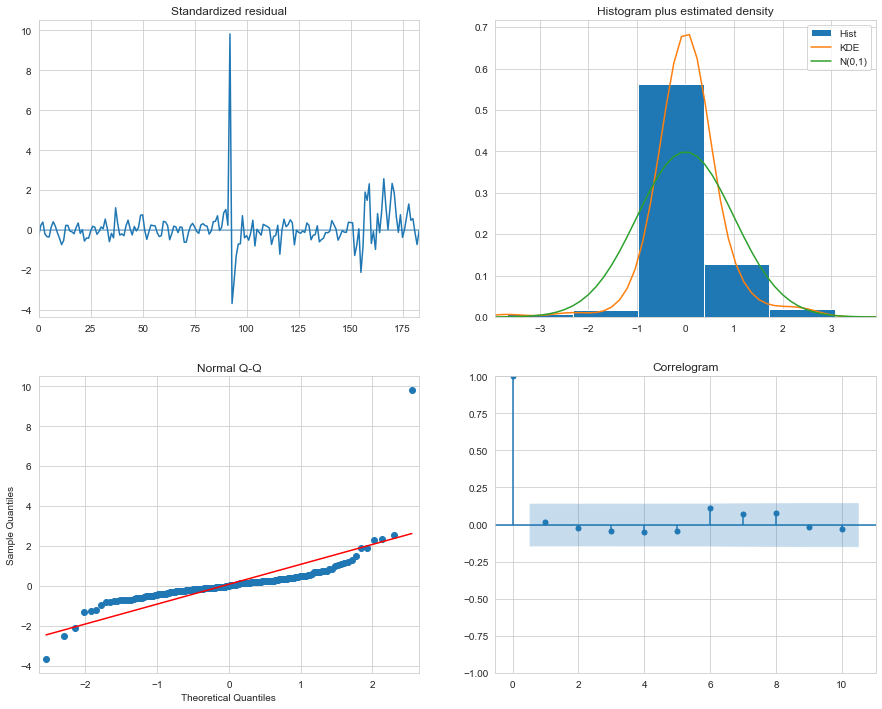

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(0,1,1)(0,1,1)[12] intercept 



In [13]:
palau_no_gt = run_sarimax(country="palau",
                          y_vars=["total"],
                          exog_var=["covid", "stringency_index"],
                          method="scaledlogit")

,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total,stringency_index,covid,palau_flights,palau_hotel,palau_travel
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,1.068426,8.334537,0.320004
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.000000,9.667343,0.952482
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.704914,6.906282,0.453967
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.798284,3.591027,0.000000
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.431326,4.111283,0.000000


training size : 184, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                -246.523
Date:                            Wed, 14 Jun 2023   AIC                            511.046
Time:                                    23:39:08   BIC                            539.980
Sample:                                         0   HQIC                           522.773
                                            - 184                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

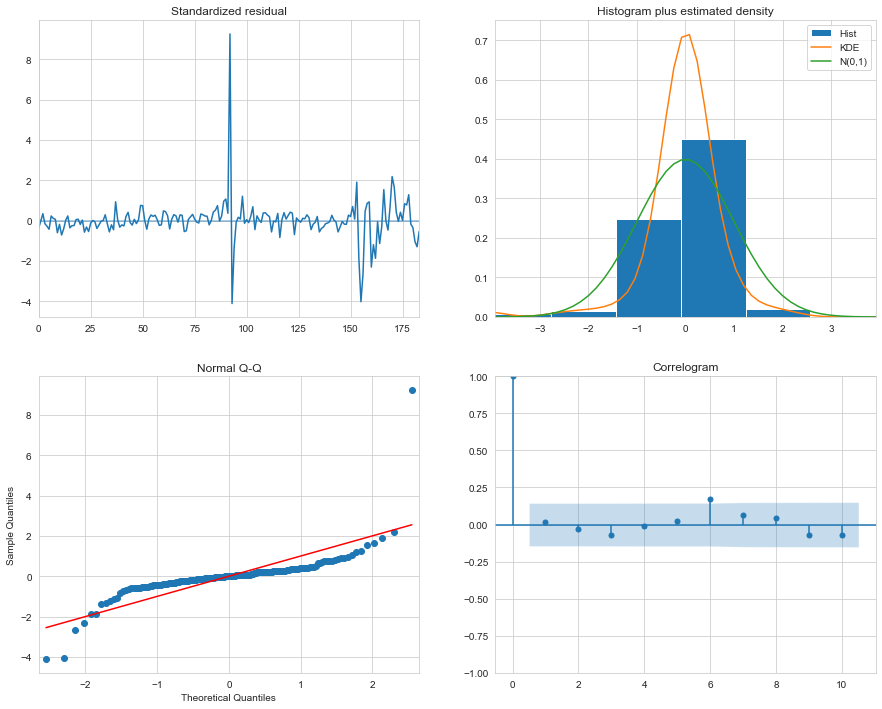

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(1,0,1)(0,1,1)[12] intercept 



In [15]:
palau_no_covid = run_sarimax(country="palau",
                          y_vars=["total"],
                          exog_var=["stringency_index", "palau_travel"],
                          method="scaledlogit")

In [16]:
calculate_evaluation(palau_no_covid["total"], palau_no_covid["total_pred"])

{'MSE': 1939914.5887213368,
 'RMSE': 1392.8081665187553,
 'MAE': 1027.3126366605,
 'SMAPE': 24.11771284687374}

In [14]:
calculate_evaluation(palau_no_gt["total"], palau_no_gt["total_pred"])

{'MSE': 1718274.4722567317,
 'RMSE': 1310.8296885014208,
 'MAE': 916.3830256150759,
 'SMAPE': 21.33401613003384}

## VARMAX

In [11]:
scaled_logit = SARIMAXPipeline.scaledlogit_transform
inverse_transform = SARIMAXPipeline.inverse_scaledlogit

In [12]:
palau_merged = pd.read_csv(filepaths[0]).drop(["Unnamed: 0", "Date"], axis=1)
palau_merged["date"] = [str(year) + '-' + str(month)
                        for year, month in zip(palau_merged.Year, palau_merged.Month)]
palau_merged["date"] = pd.to_datetime(palau_merged["date"])
palau_merged = (palau_merged.merge(oceania_index, how="left", on="date")
                .merge(gt.iloc[:, [0, -3, -2, -1]], how="left", on="date")
                .drop(["year", "month"], axis=1)
                .fillna(0))
palau_merged["covid"] = (palau_merged["date"] >= "2020-03-12").astype(int)
palau_merged.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,Number_of_flights_intl,Number_of_flights_total,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,date,stringency_index,palau flights,palau hotel,palau travel,covid
0,2019,1,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0,2019-01-01,0.0,0.493228,2.559978,0.194222,0
1,2019,2,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0,2019-02-01,0.0,0.310671,2.841414,0.282245,0
2,2019,3,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0,2019-03-01,0.0,0.386389,2.921431,0.286529,0
3,2019,4,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0,2019-04-01,0.0,0.293529,2.981907,0.338945,0
4,2019,5,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0,2019-05-01,0.0,0.306351,3.537987,0.168664,0


In [13]:
palau_merged.columns = [col.replace(" ", "_").lower() for col in palau_merged.columns]
palau_merged.head(5)

,year,month,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,japan,south_korea,taiwan,china,usa/canada,europe,others,total,date,stringency_index,palau_flights,palau_hotel,palau_travel,covid
0,2019,1,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0,2019-01-01,0.0,0.493228,2.559978,0.194222,0
1,2019,2,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0,2019-02-01,0.0,0.310671,2.841414,0.282245,0
2,2019,3,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0,2019-03-01,0.0,0.386389,2.921431,0.286529,0
3,2019,4,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0,2019-04-01,0.0,0.293529,2.981907,0.338945,0
4,2019,5,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0,2019-05-01,0.0,0.306351,3.537987,0.168664,0


In [14]:
test_cols = ["seats_arrivals_intl", "total", "palau_travel"]
get_adf_df(palau_merged, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-2.011353,0.281617,2.0,42.0,-3.596636,-2.933297,-2.604991
total,-1.838074,0.361729,6.0,38.0,-3.615509,-2.941262,-2.609200
palau_travel,-2.547037,0.104445,4.0,40.0,-3.605565,-2.937069,-2.606986


In [15]:
palau_diff = palau_merged[test_cols].diff().dropna()
get_adf_df(palau_diff, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-5.476862,0.000002,0.0,43.0,-3.592504,-2.931550,-2.604066
total,-2.622492,0.088437,5.0,38.0,-3.615509,-2.941262,-2.609200
palau_travel,-5.085595,0.000015,3.0,40.0,-3.605565,-2.937069,-2.606986


In [16]:
palau_diff2 = palau_diff.diff().dropna()
get_adf_df(palau_diff2, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-10.686152,3.828714e-19,0.0,42.0,-3.596636,-2.933297,-2.604991
total,-4.001045,1.405051e-03,6.0,36.0,-3.626652,-2.945951,-2.611671
palau_travel,-5.139137,1.168912e-05,5.0,37.0,-3.620918,-2.943539,-2.610400


### Unscaled

In [18]:
varmax_exog = palau_merged[["covid", "stringency_index"]].to_numpy()
varma_search(palau_diff, ["total", "seats_arrivals_intl",
             "palau_travel"], varmax_exog[1:])

 Running for {'p': 1, 'q': 1, 'tr': 'n'}
 Running for {'p': 1, 'q': 1, 'tr': 'c'}
 Running for {'p': 1, 'q': 1, 'tr': 't'}
 Running for {'p': 1, 'q': 1, 'tr': 'ct'}
 Running for {'p': 1, 'q': 2, 'tr': 'n'}
 Running for {'p': 1, 'q': 2, 'tr': 'c'}
 Running for {'p': 1, 'q': 2, 'tr': 't'}
 Running for {'p': 1, 'q': 2, 'tr': 'ct'}
 Running for {'p': 1, 'q': 3, 'tr': 'n'}
 Running for {'p': 1, 'q': 3, 'tr': 'c'}
 Running for {'p': 1, 'q': 3, 'tr': 't'}
 Running for {'p': 1, 'q': 3, 'tr': 'ct'}
 Running for {'p': 2, 'q': 1, 'tr': 'n'}
 Running for {'p': 2, 'q': 1, 'tr': 'c'}
 Running for {'p': 2, 'q': 1, 'tr': 't'}
 Running for {'p': 2, 'q': 1, 'tr': 'ct'}
 Running for {'p': 2, 'q': 2, 'tr': 'n'}
 Running for {'p': 2, 'q': 2, 'tr': 'c'}
 Running for {'p': 2, 'q': 2, 'tr': 't'}
 Running for {'p': 2, 'q': 2, 'tr': 'ct'}
 Running for {'p': 2, 'q': 3, 'tr': 'n'}
 Running for {'p': 2, 'q': 3, 'tr': 'c'}
 Running for {'p': 2, 'q': 3, 'tr': 't'}
 Running for {'p': 2, 'q': 3, 'tr': 'ct'}
 Running f

{'model': [(1, 1, 'n'),
  (1, 1, 'c'),
  (1, 1, 't'),
  (1, 1, 'ct'),
  (1, 2, 'n'),
  (1, 2, 'c'),
  (1, 2, 't'),
  (1, 2, 'ct'),
  (1, 3, 'n'),
  (1, 3, 'c'),
  (1, 3, 't'),
  (1, 3, 'ct'),
  (2, 1, 'n'),
  (2, 1, 'c'),
  (2, 1, 't'),
  (2, 1, 'ct'),
  (2, 2, 'n'),
  (2, 2, 'c'),
  (2, 2, 't'),
  (2, 2, 'ct'),
  (2, 3, 'n'),
  (2, 3, 'c'),
  (2, 3, 't'),
  (2, 3, 'ct'),
  (3, 1, 'n'),
  (3, 1, 'c'),
  (3, 1, 't'),
  (3, 1, 'ct'),
  (3, 2, 'n'),
  (3, 2, 'c'),
  (3, 2, 't'),
  (3, 2, 'ct'),
  (3, 3, 'n'),
  (3, 3, 'c'),
  (3, 3, 't'),
  (3, 3, 'ct')],
 'result': [1463.5746691810016,
  1468.0767222788536,
  1463.1563748983294,
  1469.9418646689776,
  1441.4798033078227,
  1445.5937486204384,
  1450.7285270037898,
  1456.2920905540318,
  1453.646687919636,
  1454.7838351008056,
  1468.5886260787656,
  1470.957902577786,
  1441.5101419394941,
  1446.9282132058045,
  1440.7850264194576,
  1448.4235890393416,
  1452.8705079682957,
  1456.6105328581332,
  1462.054418423432,
  1466.978293243

In [20]:
from statsmodels.tsa.api import VARMAX
varma_ns = VARMAX(endog=palau_diff[["total", "seats_arrivals_intl", "palau_travel"]],
               exog=varmax_exog[1:], order=(1, 2), tr="c")
varma_ns_res = varma_ns.fit(disp=False)
varma_ns_res.summary()

Dep. Variable:,"['total', 'seats_arrivals_intl', 'palau_travel']",No. Observations:,44
Model:,"VARMAX(1,2)",Log Likelihood,-680.797
,+ intercept,AIC,1445.594
Date:,"Fri, 21 Apr 2023",BIC,1520.530
Time:,13:30:48,HQIC,1473.384
Sample:,0,,
,- 44,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.23, 0.02, 0.23",Jarque-Bera (JB):,"26.76, 58.13, 0.34"
Prob(Q):,"0.63, 0.89, 0.63",Prob(JB):,"0.00, 0.00, 0.84"
Heteroskedasticity (H):,"0.16, 0.18, 0.97",Skew:,"-0.71, -1.66, 0.20"


### Scaled Logit

In [21]:
varma_cols = ["total", "seats_arrivals_intl", "palau_travel"]
for col in varma_cols[:2]:
    palau_merged["sl_"+str(col)] = scaled_logit(palau_merged[col])

In [25]:
varma = VARMAX(endog=palau_merged[["sl_total", "sl_seats_arrivals_intl", "palau_travel"]],
               exog=varmax_exog, order=(1, 1), tr="ct")
varma_res = varma.fit(disp=False)
varma_res.summary()

Dep. Variable:,"['sl_total', 'sl_seats_arrivals_intl', 'palau_travel']",No. Observations:,45
Model:,"VARMAX(1,1)",Log Likelihood,-112.196
,+ intercept,AIC,290.393
Date:,"Fri, 21 Apr 2023",BIC,350.013
Time:,13:32:06,HQIC,312.618
Sample:,0,,
,- 45,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.48, 0.31, 0.37",Jarque-Bera (JB):,"35.34, 24.94, 1.79"
Prob(Q):,"0.22, 0.58, 0.54",Prob(JB):,"0.00, 0.00, 0.41"
Heteroskedasticity (H):,"0.26, 0.07, 0.91",Skew:,"1.22, -0.04, 0.39"


In [26]:
total_pred = varma_res.get_prediction().summary_frame()
total_pred.columns.name = None

In [27]:
for col in ["total", "seats_arrivals_intl"]:
    palau_merged["sl_" + col] = scaled_logit(palau_merged[col])
    
varmax_exog = palau_merged[["covid", "stringency_index"]].to_numpy()

In [28]:
lower = palau_merged["total"].min() - 1
upper = palau_merged["total"].max() + 1

inv_lst = []
for val in total_pred["mean"]:
    inv_lst.append(inverse_transform(val, upper, lower))
palau_merged["mean"] = inv_lst

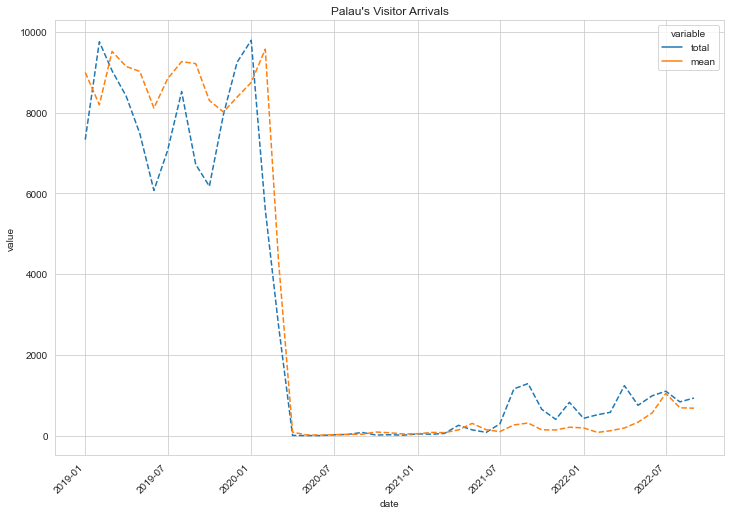

In [29]:
var_viz_df = palau_merged[["date", "total", "mean"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=var_viz_df, x="date", y="value",
             hue="variable", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.title("Palau's Visitor Arrivals")
plt.show()

In [30]:
var_mean = mean_method(palau_merged["total"])
var_naive = naive_method(palau_merged["total"])

var_metrics = pd.DataFrame()
for idx, pred in enumerate([var_mean, var_naive]):
    df = pd.DataFrame(calculate_evaluation(palau_merged["total"], pred), index=[idx])
    var_metrics = pd.concat([var_metrics, df], axis=0)
    
var_metrics.index = ["mean", "naive"]

In [31]:
pred_metrics = calculate_evaluation(palau_merged["total"], palau_merged["mean"])
pred_metrics_df = pd.DataFrame(pred_metrics, index=["VAR"])
var_metrics = pd.concat([var_metrics, pred_metrics_df], axis=0)
var_metrics

,MSE,RMSE,MAE,MAPE
mean,1.219030e+07,3491.460526,3125.890370,12924.681771
naive,1.298621e+06,1139.570483,677.477273,1301.538952
VAR,1.149672e+06,1072.227515,674.455182,146.613436


## Ratio

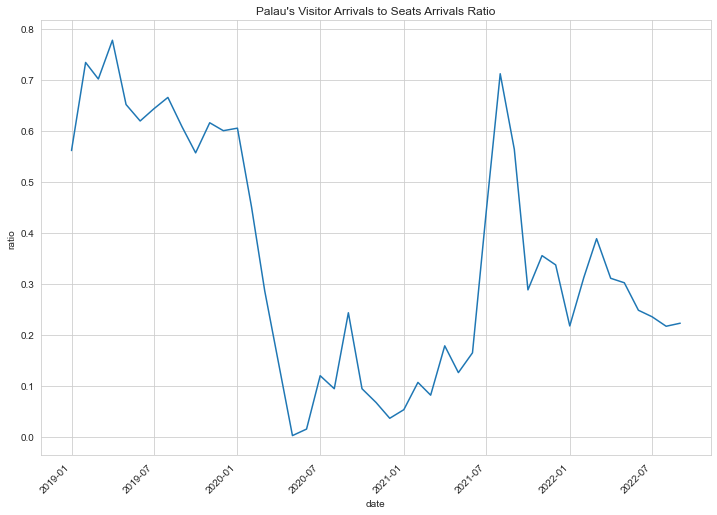

In [32]:
palau_merged["ratio"] = (palau_merged["total"])/(palau_merged["seats_arrivals_intl"])

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=palau_merged, x="date", y="ratio")
plt.xticks(rotation=45, ha='right')
plt.title("Palau's Visitor Arrivals to Seats Arrivals Ratio")
plt.show()

In [33]:
adj_ratio = []
for idx, ratio in enumerate(palau_merged["ratio"]):
    if ratio < 1:
        adj_ratio.append(ratio)
    else:
        ratio = ((palau_merged["ratio"][idx-1] + palau_merged["ratio"][idx+1]))/2
        adj_ratio.append(ratio)
        
palau_merged["adj_ratio"] = adj_ratio

In [34]:
get_adf_df(palau_merged, ["adj_ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
adj_ratio,-2.259475,0.185371,1.0,43.0,-3.592504,-2.93155,-2.604066


In [35]:
temp = palau_merged[["ratio", "adj_ratio", "stringency_index", "date"]].reset_index()
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
# temp["stringency_index"] = temp["covid"] * temp["stringency_index"]
temp = (temp.merge(gt[["date", "palau travel"]], how="left", on="date")
            .rename({"palau travel": "palau_travel"}, axis=1))
temp.head(5)

,index,ratio,adj_ratio,stringency_index,date,covid,quarter,palau_travel
0,0,0.561695,0.561695,0.0,2019-01-01,False,1,0.194222
1,1,0.734282,0.734282,0.0,2019-02-01,False,1,0.282245
2,2,0.701865,0.701865,0.0,2019-03-01,False,1,0.286529
3,3,0.777809,0.777809,0.0,2019-04-01,False,2,0.338945
4,4,0.651848,0.651848,0.0,2019-05-01,False,2,0.168664


In [36]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="adj_ratio ~ covid * stringency_index + C(quarter) + palau_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              adj_ratio   R-squared:                       0.762
Model:                            WLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     16.95
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           8.36e-10
Time:                        13:35:14   Log-Likelihood:                 34.253
No. Observations:                  45   AIC:                            -52.51
Df Residuals:                      37   BIC:                            -38.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.4637      0.074      6.305      0.000       0.315       0.613
covid[T.True]                     -0.5484      0.105     -5.240      0.000      -0.760      -0.336
C(quarter)[T.2]                   -0.0496      0.055     -0.908      0.370      -0.160       0.061
C(quarter)[T.3]                    0.0487      0.056      0.865      0.392      -0.065       0.163
C(quarter)[T.4]                    0.0115      0.059      0.196      0.846      -0.107       0.130
stringency_index                  -0.0087      0.003     -2.855      0.007      -0.015      -0.003
covid[T.True]:stringency_index     0.0116      0.004      3.184      0.003       0.004       0.019
palau_travel                       0.5390      0.178      3.029      0.004       0.178       0.900
==============================================================================
Omnibus:                        6.243   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.029
Skew:                           0.686   Prob(JB):                       0.0809
Kurtosis:                       3.894   Cond. No.                         574.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)
ratio_stats.head(5)

,index,ratio,adj_ratio,stringency_index,date,covid,quarter,palau_travel,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0,0.561695,0.561695,0.0,2019-01-01,False,1,0.194222,0.568387,0.051942,0.463144,0.673631,0.294774,0.842001
1,1,0.734282,0.734282,0.0,2019-02-01,False,1,0.282245,0.615828,0.047496,0.519592,0.712064,0.345551,0.886105
2,2,0.701865,0.701865,0.0,2019-03-01,False,1,0.286529,0.618136,0.047401,0.522092,0.714181,0.347928,0.888345
3,3,0.777809,0.777809,0.0,2019-04-01,False,2,0.338945,0.596816,0.048248,0.499057,0.694575,0.325993,0.867639
4,4,0.651848,0.651848,0.0,2019-05-01,False,2,0.168664,0.505042,0.059329,0.384831,0.625253,0.225330,0.784754


In [44]:
pred_mean = []
for idx, val in enumerate(ratio_stats["mean"]):
    pred = palau_merged["seats_arrivals_intl"][idx] * ratio_stats["mean"][idx]
    pred_mean.append(pred)

In [45]:
ratio_metrics = pd.DataFrame(calculate_evaluation(
    palau_merged["total"], np.array(pred_mean)), index=["Ratio"])

comb_metrics = pd.concat([var_metrics, ratio_metrics], axis=0)
comb_metrics

,MSE,RMSE,MAE,MAPE
mean,1.219030e+07,3491.460526,3125.890370,12924.681771
naive,1.298621e+06,1139.570483,677.477273,1301.538952
VAR,1.149672e+06,1072.227515,674.455182,146.613436
Ratio,4.945034e+05,703.209346,389.892735,177.662539


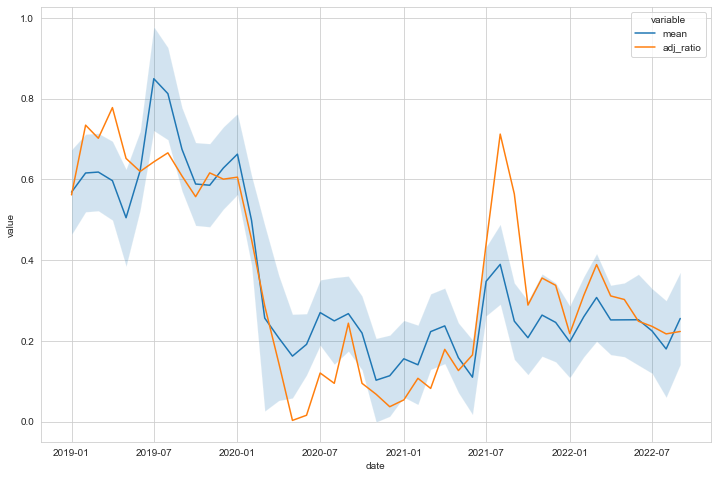

In [40]:
ratio_viz_df = ratio_stats[["mean", "adj_ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2)
plt.show()

In [41]:
stats = pd.DataFrame()
for num in range(-6, 0):
    res_test = smf.wls(
        formula="adj_ratio ~ covid * stringency_index + C(quarter) + palau_travel", data=temp[:int(num)]).fit()
    colname = "test_size_" + str(abs(num))
    predict_now = pd.DataFrame(res_test.predict(), columns=[colname])
    predict_test = pd.DataFrame(res_test.predict(temp[int(num):]),columns=[colname])
    stat = pd.concat([predict_now, predict_test], axis=0)
    stats = pd.concat([stats, stat], axis=1)
stats["date"] = palau_merged["date"]
stats["total"] = palau_merged["total"]

In [42]:
for col in stats.columns[:6]:
    stats[col] = palau_merged["seats_arrivals_intl"] * stats[col]
    
stats

,test_size_6,test_size_5,test_size_4,test_size_3,test_size_2,test_size_1,date,total
0,7502.849312,7441.292011,7394.604317,7397.890961,7399.024762,7408.417859,2019-01-01,7329.0
1,8235.499664,8202.139496,8176.903918,8178.675852,8175.089767,8171.663823,2019-02-01,9752.0
2,8008.871101,7977.924817,7954.521107,7956.164010,7952.465375,7948.533044,2019-03-01,9033.0
3,6347.006805,6408.054496,6452.074757,6449.132788,6447.185584,6445.828774,2019-04-01,8405.0
4,5737.801426,5753.657022,5763.150455,5762.656337,5768.509944,5788.770581,2019-05-01,7478.0
5,5986.557467,6053.244484,6101.780232,6098.503990,6094.904599,6088.650134,2019-06-01,6071.0
6,9265.694259,9302.687859,9335.104116,9332.522333,9337.673935,9333.576236,2019-07-01,7054.0
7,10362.005559,10383.141705,10404.208715,10402.379266,10411.955492,10416.940426,2019-08-01,8518.0
8,7491.880308,7439.374422,7403.735868,7405.956918,7425.661596,7461.317748,2019-09-01,6714.0
9,6578.260173,6546.634613,6520.583129,6522.559099,6518.028916,6513.005862,2019-10-01,6174.0


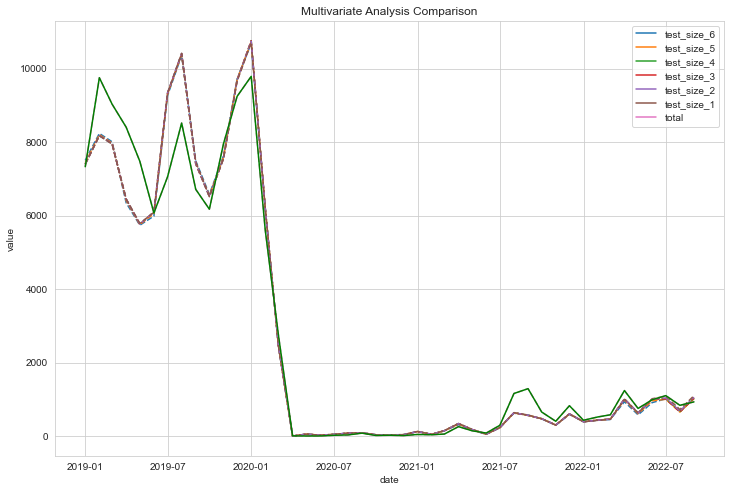

In [43]:
stats_viz_df = stats.melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=stats_viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=palau_merged, x="date", y="total", color="green")
plt.title("Multivariate Analysis Comparison")
plt.show()